<a href="https://colab.research.google.com/github/rakibulhaque9954/Emotion_model-sec-17-Vision-Transfomers/blob/main/Emotion_model(sec_17)Vision_Transfomers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libararies and Installations

## Imports

In [1]:
import tensorflow as tf
import numpy as np
# import wandb
import matplotlib.pyplot as plt
from keras.layers import InputLayer, Conv2D, BatchNormalization, Flatten, Dense, MaxPool2D, Dropout, Rescaling, RandomRotation, RandomFlip, RandomContrast
from keras.regularizers import L2
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
# import importlib

# tfp = importlib.import_module("tensorflow_probability") # another way to import libraries
import tensorflow_probability as tfp
from keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cv2
# from tensorflow.train import BytesList, Floatlist, Int64List
# from tensorflow.train import Example, Features, Feature

In [2]:
 !pip3 install kaggle





In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


In [4]:
# giving user raed and write rights in kaggle file
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
# copying api command of dataset from kaggle.json and downloading
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

100% 309M/309M [00:14<00:00, 20.6MB/s]
100% 309M/309M [00:14<00:00, 22.1MB/s]


In [ ]:
!unzip 'human-emotions-datasethes.zip' -d '/content/dataset'

# Data Preprocessing

In [86]:
train_directory = '/content/dataset/Emotions Dataset/Emotions Dataset/train'
# using test dataset as val dataset
validation_directory = '/content/dataset/Emotions Dataset/Emotions Dataset/test'
CLASS_NAMES = ['angry', 'happy', 'sad'] # keep the order of the classses for consistency

In [8]:
CONFIGURATION =  {
    'BATCH_SIZE' : 32,
    'IM_SIZE': 256,
    'LEARNING_RATE': 0.001,
    'N_EPOCHS': 20,
    'DROPOUT_RATE': 0.0,
    'REGULARIZATION_RATE': 0.0,
    'N_FILTERS': 6,
    'KERNEL_SIZE': 3,
    'N_STRIDES': 1,
    'POOL_SIZE': 2,
    'N_DENSE_1': 100,
    'N_DENSE_2': 10,
    'NUM_CLASSES': 3,
    'PATCH_SIZE': 16

}

In [87]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CONFIGURATION['CLASS_NAMES'],
    color_mode= 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    seed = 99,
    shuffle = True

)

Found 6799 files belonging to 3 classes.


In [120]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names =  CONFIGURATION['CLASS_NAMES'],
    color_mode= 'rgb',
    batch_size = 1,
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    seed = 99,
    shuffle = True

)

Found 2278 files belonging to 3 classes.


In [ ]:
for i in val_dataset.take(1):
  # visualizing labels and their respective values
  print(i) # binary vectors or int class depending on the mode

# Dataset Visualization

In [ ]:
plt.figure(figsize = (12, 12))
for images, labels in train_dataset.take(1): #taking 1 batch of images
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i]/255.0) # normalization
    label_index = tf.argmax(labels[i]).numpy()
    plt.title(CLASS_NAMES[label_index])
    # plt.title((tf.argmax(labels[i])).numpy()) printing when printing the index value of classes when using bianry vector mode
    ax.axis('off')

# Data Augmentation



In [89]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor= (-0.025, 0.025)), # rotation is limited
    RandomFlip(mode= 'horizontal'),
    RandomContrast(factor= 0.1)

])

In [90]:
def augment_layer(image, label):
    return augment_layers(image, training = True), label

# Dataset Preparation

In [91]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)
# using cutmix thats why in comments

In [121]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [93]:
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    tf.keras.layers.Rescaling(1./255)
]) # its good for deployment and prevents extra steps

<hr>
<h1>Modeling</h1>
<hr>

#Vision Transformers(ViT)

## Extracting Patches/Patch Encoder

In [57]:
test_image = cv2.imread('/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/110020.jpg_brightness_2.jpg')

test_image = cv2.resize(test_image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))

In [58]:
patches = tf.image.extract_patches(images = tf.expand_dims(test_image, axis = 0),
                           sizes = [1, CONFIGURATION['PATCH_SIZE'], CONFIGURATION['PATCH_SIZE'], 1],
                           strides = [1, CONFIGURATION['PATCH_SIZE'], CONFIGURATION['PATCH_SIZE'], 1], # we wanna keep the strides 16, 16 for not missing any part
                           rates = [ 1, 1, 1, 1],
                           padding = 'VALID')

In [59]:
print(patches.shape)
# basically the 16 x 16 patch size will equate to 256 and since there are 3 channels(RGB) then 256 x 3 = 768,
# this explains the shape
# the we need to reshape the image so that the patches are in sequence and belong to the same sequence
patches = tf.reshape(patches, (patches.shape[0], -1, 768)) # -1 means the last length as well which is -1 we can do it explicitly as well
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


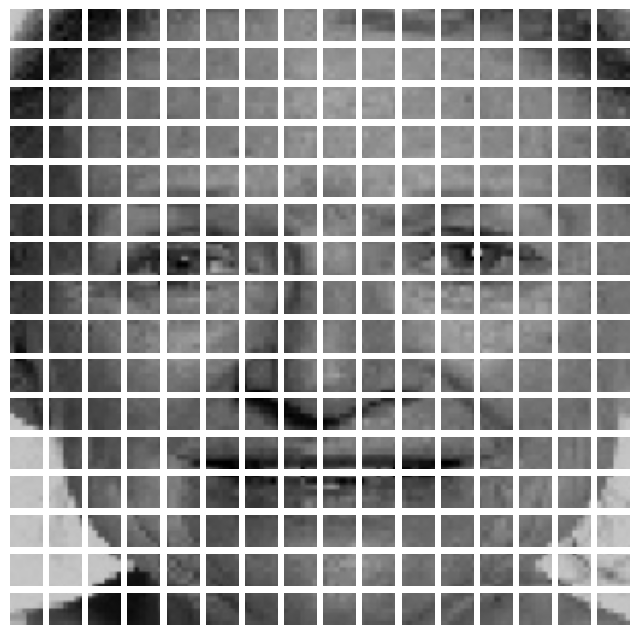

In [60]:
# visualize the patches
plt.figure(figsize= (8, 8))

for i in range(patches.shape[1]):

    ax = plt.subplot(16, 16, i + 1)
    plt.imshow(tf.reshape(patches[0, i, :], (16, 16, 3)))
    plt.axis('off')


## Patch Encoder Layer


In [139]:
from keras.layers import Layer
class PatchEncoder(Layer):
    def __init__(self, N_PATCHES, HIDDEN_SIZE):
        super(PatchEncoder, self).__init__(name = 'patch_encoder')

        self.linear_projection = Dense(HIDDEN_SIZE)
        self.positional_embedding = tf.keras.layers.Embedding(N_PATCHES, HIDDEN_SIZE) # adding the position of the embedding
        self.N_PATCHES = N_PATCHES

    def call(self, x, training = False):
        batch_size = tf.shape(x)[0]  # Get the actual batch size
        patch_size = CONFIGURATION['PATCH_SIZE']

        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, patch_size, patch_size, 1],
            strides=[1, patch_size, patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID')

        patches = tf.reshape(patches, (batch_size, -1, patches.shape[-1]))  # Reshape with respect to batch size

        # Calculate positional embeddings for each example in the batch
        embedding_input = tf.range(start=0, limit=self.N_PATCHES, delta=1)
        embedding_input = tf.expand_dims(embedding_input, axis=0)  # Add batch dimension to the input
        embedding_input = tf.tile(embedding_input, [batch_size, 1])  # Repeat for each example in the batch

        output = self.linear_projection(patches) + self.positional_embedding(embedding_input)

        return output

In [ ]:
patch_enc = PatchEncoder(256, 768)
example_image = tf.zeros([32, 256, 256, 3]) # creating an example image with input size
patch_enc(example_image)

## Transformer Encoder

In [140]:
from keras.src.layers import MultiHeadAttention

from keras.layers import Layer, LayerNormalization, Add
class TransformerEncoder(Layer):
    def __init__(self, N_HEADS, HIDDEN_SIZE):
        super(TransformerEncoder, self).__init__(name = 'Transformer_encoder')

        self.layer_norm_1 = LayerNormalization()
        self.layer_norm_2 = LayerNormalization()


        self.multi_head_att = MultiHeadAttention(N_HEADS, HIDDEN_SIZE)

        self.dense_1 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu) # gelu layer
        self.dense_2 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)

    def call(self, input):
      x_1 = self.layer_norm_1(input)
      x_1 = self.multi_head_att(x_1, x_1) # passing value and query

      x_1 = Add()([x_1, input])

      x_2 = self.layer_norm_2(x_1)
      x_2 = self.dense_1(x_2)

      output = self.dense_2(x_2)
      output = Add()([output, x_1])

      return output

In [141]:

trans_enc = TransformerEncoder(8, 768)
trans_enc(tf.zeros([1, 256, 768])) # example and testing the code

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

## ViT Model

In [142]:
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
class ViT(tf.keras.models.Model): # 34 layers thats why resnet34
    def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
        super(ViT, self).__init__(name = 'vision_transfomer')

        self.N_LAYERS = N_LAYERS
        self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE) # calling the patch_enc layer created earlier

        self.transformer_encoder = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)] # calling the trans_enc layer

        self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
        self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)
        self.dense_3 = Dense(CONFIGURATION['NUM_CLASSES'], activation = 'softmax') # classification




    def call(self, input, training = True):

      x = self.patch_encoder(input) # passing the sequence or image in the pacth encoder first


      for i in range(self.N_LAYERS):
        x = self.transformer_encoder[i](x)

      x = Flatten()(x)

      # MLP Head
      x = self.dense_1(x)
      x = self.dense_2(x)

      return self.dense_3(x)

In [143]:
vit = ViT(N_HEADS = 4, HIDDEN_SIZE = 768, N_PATCHES = 256, N_LAYERS = 2, N_DENSE_UNITS = 128)
vit(tf.zeros([32, 256, 256, 3]))

<tf.Tensor: shape=(32, 3), dtype=float32, numpy=
array([[0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
       [0.18233417, 0.26948628, 0.54817957],
      

In [110]:
vit.summary()

Model: "vision_transfomer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_encoder (PatchEncode  multiple                  787200    
 r)                                                              
                                                                 
 Transformer_encoder (Trans  multiple                  10631424  
 formerEncoder)                                                  
                                                                 
 Transformer_encoder (Trans  multiple                  10631424  
 formerEncoder)                                                  
                                                                 
 dense_94 (Dense)            multiple                  25165952  
                                                                 
 dense_95 (Dense)            multiple                  16512     
                                                 

In [144]:
vit.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
                     loss = CategoricalCrossentropy(),
                     metrics = [CategoricalAccuracy(name = 'accuracy'), TopKCategoricalAccuracy(k = 2, name = 'top_k_accuracy')]
    )

In [113]:
tf.debugging.check_numerics

<function tensorflow.python.ops.gen_array_ops.check_numerics(tensor, message, name=None)>

In [145]:
history = vit.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1
)

Epoch 1/20
213/213 [==============================] - 103s 443ms/step - loss: 1800.4244 - accuracy: 0.3778 - top_k_accuracy: 0.9381 - val_loss: 50.5012 - val_accuracy: 0.3745 - val_top_k_accuracy: 0.7906
Epoch 2/20
213/213 [==============================] - 97s 455ms/step - loss: 27.0507 - accuracy: 0.4479 - top_k_accuracy: 0.7857 - val_loss: 18.7182 - val_accuracy: 0.3938 - val_top_k_accuracy: 0.7322
Epoch 3/20
  1/213 [..............................] - ETA: 2:56 - loss: 16.0929 - accuracy: 0.5312 - top_k_accuracy: 0.7500

KeyboardInterrupt: ignored

Irregular batch sizes at the end can lead to error, so be careful when shaping for batches, make it more dynamic.
ViT need very large dataset to get to good proficiency which then makes it easier to finetune for smaller datasets like this. They also need goof training time but less compared to Resnets

#Hugging Face Transformers


## Installation

In [ ]:
!pip install transformers

## Model without weights and training
The model can be just initialised without going throught the hassle of creating one from scratch

In [24]:
from transformers import ViTConfig, ViTModel

# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig()

# Initializing a model (with random weights) from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

# Accessing the model configuration
configuration = model.config

In [25]:
print(configuration) # all the params value that can be changed and finetuned accordingly

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.33.1"
}



## Pretrained ViT Model(google/vit)

In [43]:
from keras.layers import Permute
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.Rescaling(1./255),
    # Changing the shape of each image by permuting for ex: (1, 224, 224, 3) -> (1, 3, 224, 224)
    # This is to match the shape of the hugging face pretrained model, just reconfiguring the order not the values itself
    # default is (Batch, Height, Width, Channels) but permute just reconfigures the order
    # After Permute -> (Batch, Channels, Height, Width)(using indexes of shape)
    Permute((3, 1, 2))
])

In [44]:
from transformers import TFViTModel
from keras.layers import Input


hf_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
hf_model.trainable = False # this is important otehrwise there is gradients computation error as it can lead to weights being updated during back propogation

inputs = Input(shape = (256, 256, 3)) # shape is different as set by different models
x = resize_rescale_layers(inputs) # reconfiguring the order of the shape
x = hf_model.vit(x)[0][:, 0, :] # output preference and shape

# classifier
output = Dense(CONFIGURATION['NUM_CLASSES'], activation = 'softmax')(x)
# ft is for fine-tuned
ft_hf_model = tf.keras.Model(inputs = inputs, outputs = output)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


### Confusion Matrix CallBack()

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,

    )

In [127]:

from keras.callbacks import Callback
class LogConfMatrix(Callback):
  def on_epoch_end(self, epoch, logs):
    predicted = []
    labels = []

    for im, label in validation_dataset:
      predicted.append(ft_hf_model(im))
      labels.append(label.numpy())

    pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
    lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

    cm = wandb.plot.confusion_matrix(
        y_true=lab,
        preds=pred,
        class_names=CONFIGURATION["CLASS_NAMES"])

    wandb.log({"conf_mat": cm})

### Log Results Table Callback()

In [128]:
class LogResultsTable(Callback):
  def on_epoch_end(self, epoch, logs):
    columns = ['image', 'Predicted', 'Label']

    val_table = wandb.Table(columns = columns)  # validation table

    for im, label in validation_dataset.take(25):

      pred = CONFIGURATION['CLASS_NAMES'][tf.argmax(ft_hf_model(im), axis = -1).numpy()[0]]
      label = CONFIGURATION['CLASS_NAMES'][tf.argmax(label, axis = -1).numpy()[0]]

      row = [wandb.Image(im), pred, label]

      val_table.add_data(*row)

    wandb.log({'Model Results': val_table})


### Compile and Fit

In [129]:
ft_hf_model.compile(
     optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']), #learning rate needs to be lower when finetuning a model
                     loss = CategoricalCrossentropy(),
                     metrics = [CategoricalAccuracy(name = 'accuracy'), TopKCategoricalAccuracy(k = 2, name = 'top_k_accuracy')]
    )


In [130]:
history = ft_hf_model.fit(
    training_dataset.take(20),
    validation_data = validation_dataset,
    epochs = 3,
    verbose = 1,
    callbacks = [WandbCallback(), LogResultsTable(), LogConfMatrix()] # logging data to wandb
)

Epoch 1/3
20/20 [==============================] - ETA: 0s - loss: 0.5048 - accuracy: 0.8031 - top_k_accuracy: 0.9516

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230914_084519-u850qujd/files/model-best)... Done. 0.9s


20/20 [==============================] - 534s 27s/step - loss: 0.5048 - accuracy: 0.8031 - top_k_accuracy: 0.9516 - val_loss: 0.5719 - val_accuracy: 0.7546 - val_top_k_accuracy: 0.9315
Epoch 2/3
20/20 [==============================] - ETA: 0s - loss: 0.5106 - accuracy: 0.8000 - top_k_accuracy: 0.9406

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230914_084519-u850qujd/files/model-best)... Done. 0.9s


20/20 [==============================] - 521s 27s/step - loss: 0.5106 - accuracy: 0.8000 - top_k_accuracy: 0.9406 - val_loss: 0.5699 - val_accuracy: 0.7616 - val_top_k_accuracy: 0.9284
Epoch 3/3
20/20 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.8078 - top_k_accuracy: 0.9594

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230914_084519-u850qujd/files/model-best)... Done. 0.9s


20/20 [==============================] - 522s 27s/step - loss: 0.4871 - accuracy: 0.8078 - top_k_accuracy: 0.9594 - val_loss: 0.5699 - val_accuracy: 0.7603 - val_top_k_accuracy: 0.9363


## Logging in to Wandb

### Wandb Installation

In [76]:
!pip install wandb

In [77]:
import wandb
from wandb.keras import WandbCallback

In [78]:
!wandb login

wandb: Currently logged in as: rakibulhaque9954. Use `wandb login --relogin` to force relogin


In [79]:
wandb.init(project = 'Emotion_detection', entity = 'rakibulhaque9954')

accuracy,▁▅▆▄▆██
epoch,▁▅█▁▁▁▁
loss,█▅▄▃▂▁▁
top_k_accuracy,▁▅▅▅███
val_accuracy,▁▃▅▆▇██
val_loss,█▆▅▃▂▂▁
val_top_k_accuracy,▁▃▅▆▅▇█
accuracy,0.75313
best_epoch,0
best_val_loss,0.62489
epoch,0


In [80]:
wandb.config =  {
    'BATCH_SIZE' : 32,
    'IM_SIZE': 256,
    'LEARNING_RATE': 0.001,
    'N_EPOCHS': 20,
    'DROPOUT_RATE': 0.0,
    'REGULARIZATION_RATE': 0.0,
    'N_FILTERS': 6,
    'KERNEL_SIZE': 3,
    'N_STRIDES': 1,
    'POOL_SIZE': 2,
    'N_DENSE_1': 100,
    'N_DENSE_2': 10,
    'NUM_CLASSES': 3,
    'PATCH_SIZE': 16,
    'CLASS_NAMES': ['angry', 'happy', 'sad']

}

In [81]:
CONFIGURATION = wandb.config

#Testing hf Model

In [83]:
# testing
test_image = '/content/dataset/Emotions Dataset/Emotions Dataset/test/angry/12143.jpg_rotation_2.jpg'
test_image = cv2.imread(test_image)
test_image = cv2.resize(test_image, (256, 256))
print(test_image.shape)
test_image = tf.expand_dims(test_image, axis = 0)
print(test_image.shape)


(256, 256, 3)
(1, 256, 256, 3)


In [87]:
ft_hf_model.evaluate(validation_dataset)

72/72 [==============================] - 34s 435ms/step - loss: 1.1437 - accuracy: 0.3033 - top_k_accuracy: 0.6216


[1.1437424421310425, 0.3033362627029419, 0.6215978860855103]

In [86]:
CLASS_NAMES[np.argmax(ft_hf_model.predict(test_image))]

1/1 [==============================] - 3s 3s/step


'sad'

# Just misalleneous

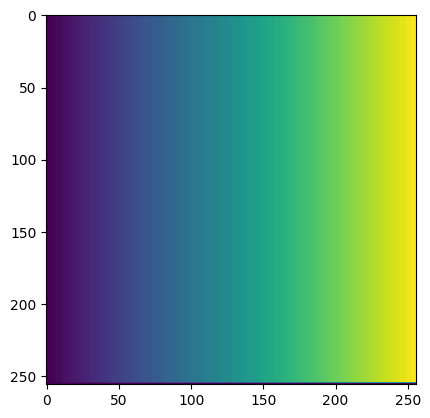

In [55]:

# plt.imshow(np.ones([256, 256, 3]))
image = np.zeros((256, 256), dtype = np.uint8)
for i in range(256):
  image[: i] = np.linspace(0, 76, 256, dtype = np.uint8)

plt.imshow(image)

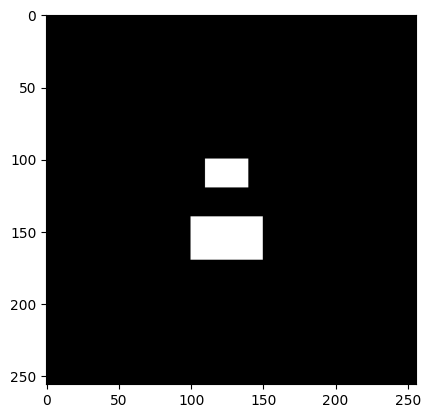

In [58]:
# Define the dimensions of the image
height, width = 256, 256

# Create an empty grayscale image filled with zeros
image = np.zeros((height, width, 3), dtype=np.uint8)

# Set pixel values to create a basic cat face
# You can modify these pixel values to create your desired shape
image[100:120, 110:140, :] = [255, 255, 255]  # White pixels for the eyes
image[130:140, 120:130, :] = [0, 0, 0]        # Black pixels for the nose
image[150:160, 110:150, :] = [255, 0, 0]      # Red pixels for the mouth
image[140:170, 100:150, :] = [255, 255, 255]  # White pixels for the face


# Display the image using matplotlib
plt.imshow(image)
# just for fun trying to create shapes using tensor and numpy

# Training

In [76]:
# when the dataset is in vector mode or categorical mode [0, 1, 0] belongs to class 2 for instance
loss_function = CategoricalCrossentropy()
# incase our dataset mode is int where labels are [0, 1, 2]then we use:
# loss_function = SparseCategoricalCrossentropy()

In [77]:
metrics = [CategoricalAccuracy(name = 'accuracy'), TopKCategoricalAccuracy(k = 2, name = 'top_k_accuracy')]


# Evaluation

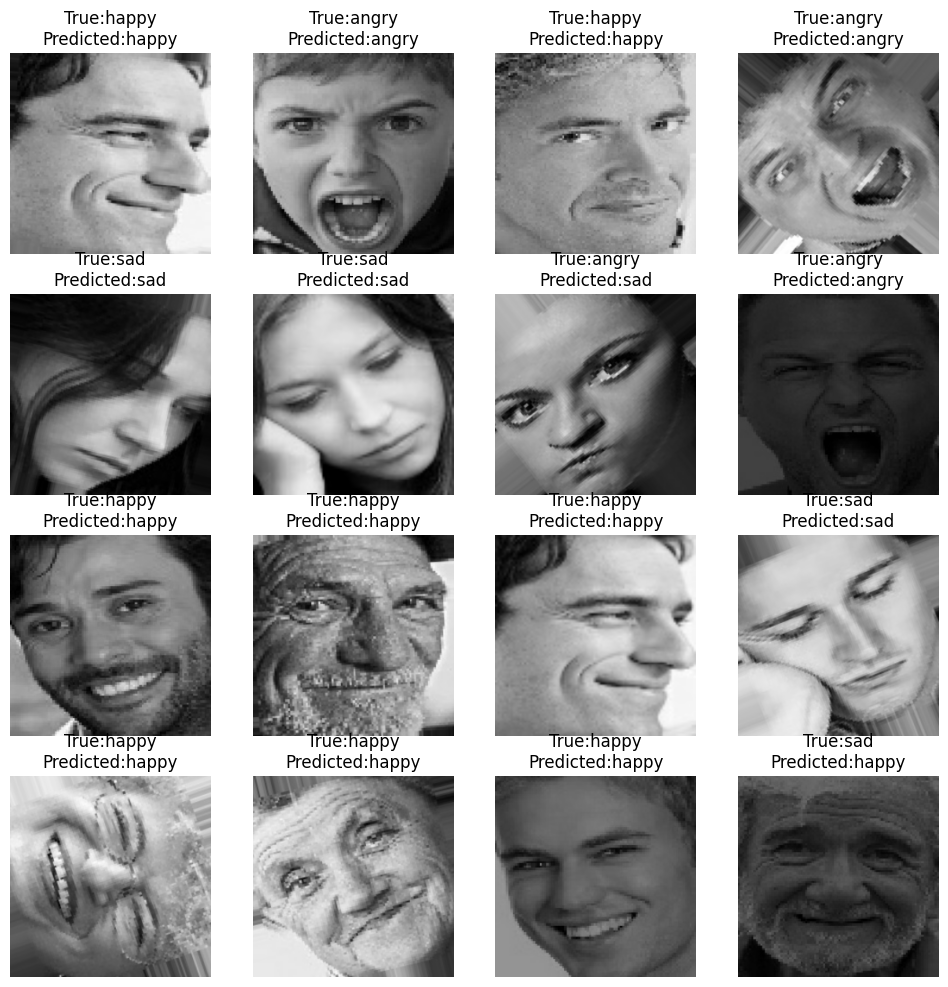

In [ ]:
plt.figure(figsize = (12, 12))
for images, labels in validation_dataset.take(1): #taking 1 batch of images
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i]/255.0) # normalization
    label_index = tf.argmax(labels[i]).numpy()
    predicted_index = tf.argmax(ensemble_model(tf.expand_dims(images[i], axis = 0)).numpy()[0])
    plt.title('True:' + CLASS_NAMES[label_index] + '\n' + 'Predicted:' + CLASS_NAMES[predicted_index])
    ax.axis('off')

In [ ]:
14/16 # accuracy rate using ensembling

0.875

# Testing

In [ ]:
test_image = cv2.imread('/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/110020.jpg_brightness_2.jpg')

test_image = cv2.resize(test_image, (256, 256))
# converting image to tensor
image = tf.constant(test_image, dtype = tf.float32)

# expanding dimensions or batching
image = tf.expand_dims(image, axis = 0) # axis = 0 means adding dimesion along the front for instance: (224, 224, 3) -> (0, 224, 224, 3) batched tensor

print(CLASS_NAMES[tf.argmax(ensemble_model(image), axis = -1).numpy()[0]]) # printing alongwith class since our dataset was preset with vector mode

happy


# Confusion matrix

In [ ]:
predicted = []
labels = []
for im, label in validation_dataset:
    predicted.append(ensemble_model(im))
    labels.append(label.numpy())


In [ ]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[0 0 1 ... 1 2 1]
[0 0 1 ... 1 2 1]


In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
label = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[400  39  76]
 [ 17 926  63]
 [ 30  67 660]]


Text(0.5, 58.7222222222222, 'Predicted')

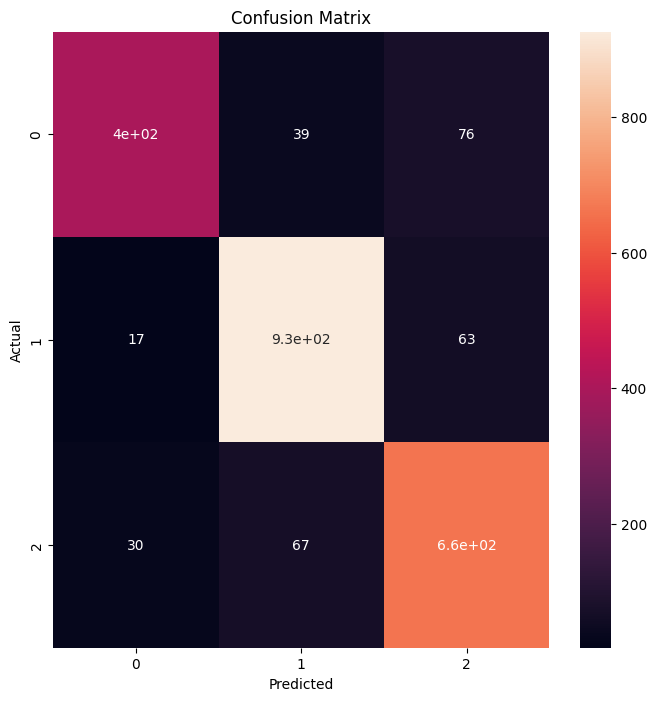

In [ ]:
cm = confusion_matrix(label , pred)
print(cm)
plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Tensorflow Records

## Augmenting Dataset before creating records and sending to unbacthing

In [ ]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
)

In [ ]:
validation_dataset = (
    val_dataset
    # .prefetch(tf.data.AUTOTUNE)
)

## Unabatching

In [ ]:
training_dataset = (
    training_dataset
    .unbatch()
)

In [ ]:
validation_dataset = (
    validation_dataset
    .unbatch()
)

In [ ]:
def create_example(image, label):
    bytes_feature = tf.train.Feature(
        bytes_list = tf.train.BytesList(value = [image])
    )

    int_feature = tf.train.Feature(
        int64_list = tf.train.Int64List(value = [int(label[0])])
    )

    example = tf.train.Example(
        features = tf.train.Features( feature =
                                    {
                                        'labels' : int_feature, # because classes are in int
                                        'images' : bytes_feature # because images are supposed to be in bytes
                                    })
    )
    return example.SerializeToString()

In [ ]:
NUM_SHARDS = 10
PATH = '/Users/boss/Desktop/Python_files.nosync/ML_projects_git_commit.nosync/Emotion-detection-model/tf-records/shard_{:02d}.tfrecord'


In [ ]:
def encode_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    image = tf.io.encode_jpeg(image)
    return image, label

In [ ]:
encoded_dataset = (
    training_dataset
    .map(encode_image)
)

## Saving the dataset

In [ ]:
for shard_number in range(NUM_SHARDS):

    sharded_dataset = (
        encoded_dataset
        .shard(NUM_SHARDS, shard_number)
        .as_numpy_iterator()
    )

    with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
        for image, label in sharded_dataset:
            file_writer.write(create_example(image, label))

## Reconstruction of Dataset for usage

In [ ]:
reconstruct_dataset = tf.data.TFRecordDataset(filenames= [ PATH.format(p) for p in range(NUM_SHARDS)])

In [ ]:
l = [ PATH.format(p) for p in range(NUM_SHARDS)]
print(l)

['/Users/boss/Desktop/Python_files.nosync/ML_projects_git_commit.nosync/Emotion-detection-model/tf-records/shard_00.tfrecord', '/Users/boss/Desktop/Python_files.nosync/ML_projects_git_commit.nosync/Emotion-detection-model/tf-records/shard_01.tfrecord', '/Users/boss/Desktop/Python_files.nosync/ML_projects_git_commit.nosync/Emotion-detection-model/tf-records/shard_02.tfrecord', '/Users/boss/Desktop/Python_files.nosync/ML_projects_git_commit.nosync/Emotion-detection-model/tf-records/shard_03.tfrecord', '/Users/boss/Desktop/Python_files.nosync/ML_projects_git_commit.nosync/Emotion-detection-model/tf-records/shard_04.tfrecord', '/Users/boss/Desktop/Python_files.nosync/ML_projects_git_commit.nosync/Emotion-detection-model/tf-records/shard_05.tfrecord', '/Users/boss/Desktop/Python_files.nosync/ML_projects_git_commit.nosync/Emotion-detection-model/tf-records/shard_06.tfrecord', '/Users/boss/Desktop/Python_files.nosync/ML_projects_git_commit.nosync/Emotion-detection-model/tf-records/shard_07.tf

In [ ]:
def parse_tfrecords(example):

    feature_description = {
        'images' : tf.io.FixedLenFeature([], tf.string),
        'labels' : tf.io.FixedLenFeature([], tf.int64)
    }

    example = tf.io.parse_single_example(example, feature_description)
    example['images'] = tf.io.decode_jpeg(example['images'], channels = 3)

    return example['images'], example['labels']

In [ ]:
parsed_dataset = (
    reconstruct_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION['BATCH_SIZE'])
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for i in parsed_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=uint8, numpy=
array([[[[131, 131, 131],
         [ 73,  73,  73],
         [165, 165, 165],
         ...,
         [ 55,  55,  55],
         [125, 125, 125],
         [200, 200, 200]],

        [[138, 138, 138],
         [188, 188, 188],
         [159, 159, 159],
         ...,
         [102, 102, 102],
         [ 35,  35,  35],
         [150, 150, 150]],

        [[238, 238, 238],
         [ 37,  37,  37],
         [ 39,  39,  39],
         ...,
         [137, 137, 137],
         [204, 204, 204],
         [164, 164, 164]],

        ...,

        [[ 77,  77,  77],
         [147, 147, 147],
         [134, 134, 134],
         ...,
         [120, 120, 120],
         [117, 117, 117],
         [ 52,  52,  52]],

        [[ 17,  17,  17],
         [145, 145, 145],
         [223, 223, 223],
         ...,
         [234, 234, 234],
         [  3,   3,   3],
         [249, 249, 249]],

        [[ 50,  50,  50],
         [ 31,  31,  31],
         [165, 1

In [ ]:
# the labels can be again preset to class numbers or int mode by using argmax